In [513]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [575]:
signal_df = pd.read_csv('../data/signaltest1.csv')
sp500_df = pd.read_excel('../data/sp_500_constituents.xlsx')

In [576]:
signal_df

,date,entity,classification,softmax_scores
0,2020-06-01 19:26:12+00:00,Ted Baker,NEUTRAL,"{'positive': 0.001163970329798758, 'negative':..."
1,2020-06-01 19:26:12+00:00,Rottweiler,NEUTRAL,"{'positive': 0.0001504293759353459, 'negative'..."
2,2020-06-01 19:26:12+00:00,Kelvin,NEGATIVE,"{'positive': 0.0002105771709466353, 'negative'..."
3,2020-06-01 19:26:12+00:00,Toscafund,NEUTRAL,"{'positive': 0.0004427890235092491, 'negative'..."
4,2020-06-01 19:26:12+00:00,Ugly Brown Building,NEUTRAL,"{'positive': 0.00026831135619431734, 'negative..."
...,...,...,...,...
44797,2020-12-03 19:15:59+00:00,Public Health England,NEUTRAL,"{'positive': 0.00010575482883723453, 'negative..."
44798,2020-12-03 19:15:59+00:00,Twitter,NEUTRAL,"{'positive': 0.00010634599311742932, 'negative..."
44799,2020-12-03 19:15:59+00:00,Department for Transport,NEUTRAL,"{'positive': 5.154808604856953e-05, 'negative'..."
44800,2020-12-03 19:15:59+00:00,DfT,NEUTRAL,"{'positive': 0.00010575482883723453, 'negative..."


In [577]:
from collections import Counter
Counter(signal_df[signal_df['date'] == '2020-09-25 13:11:07+00:00']['entity'])

Counter({'CVA': 1, 'Revolution': 1, 'Langton Capital': 1})

In [578]:
Counter(signal_df[signal_df['date'] == '2020-09-28 16:04:37+00:00']['entity'])

Counter({'Springboard': 1,
         'British Retail Consortium': 1,
         'Retail Economics': 1,
         'ShopperTrak': 1,
         'Re-leased': 1})

In [579]:
import re
import pandas as pd

# --- 1) Helpers --------------------------------------------------------------

# normalize names/tickers to make matching robust
def _norm(s: str) -> str:
    if pd.isna(s): 
        return ""
    s = s.lower()
    s = s.replace("&", " and ")
    # remove common company suffixes
    s = re.sub(r"\b(co|corp|corporation|inc|inc\.|ltd|plc|company|the)\b", " ", s)
    # keep only letters/digits/spaces
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _split_keywords(s: str):
    if pd.isna(s) or not s:
        return []
    # keywords appear comma-separated (and sometimes with slashes/pipes/semicolons)
    return [k.strip() for k in re.split(r"[,\|/;]", s) if k.strip()]

# --- 2) Build a normalized keyword → ticker map from sp500_df ----------------

# Collect all aliases for each row: Ticker, Company Name, and Search Keywords
aliases_map = {}
for _, r in sp500_df.iterrows():
    ticker = str(r.get("Ticker", "")).strip()
    comps = [ticker, str(r.get("Company Name", ""))]
    comps += _split_keywords(str(r.get("Search Keywords", "")))
    # add both raw and normalized variants to the dictionary
    for alias in comps:
        if not alias:
            continue
        aliases_map[_norm(alias)] = ticker

# --- 3) Exact/alias match on normalized entity --------------------------------

signal_df = signal_df.copy()
signal_df["entity_norm"] = signal_df["entity"].map(_norm)
signal_df["matched_ticker"] = signal_df["entity_norm"].map(aliases_map)



In [580]:
signal_df.matched_ticker.value_counts().head(10)

matched_ticker
META     291
GOOGL    228
AMZN     199
AAPL     192
MSFT     124
BA       106
PFE      105
TSLA      74
GS        59
DIS       49
Name: count, dtype: int64

In [581]:
signal_df = signal_df.drop_duplicates(subset=['matched_ticker', 'date'])

In [582]:
signal_df[signal_df['matched_ticker'] == 'MSFT'].sort_values('date')

,date,entity,classification,softmax_scores,entity_norm,matched_ticker
5533,2020-06-03 11:15:24+00:00,Microsoft,NEUTRAL,"{'positive': 0.008874807506799698, 'negative':...",microsoft,MSFT
5463,2020-06-03 14:25:16+00:00,Microsoft,NEUTRAL,"{'positive': 0.00016267951286863536, 'negative...",microsoft,MSFT
5052,2020-06-04 20:13:43+00:00,Microsoft,NEUTRAL,"{'positive': 5.2562172641046345e-05, 'negative...",microsoft,MSFT
4641,2020-06-08 14:36:19+00:00,Microsoft,NEUTRAL,"{'positive': 0.00037911522667855024, 'negative...",microsoft,MSFT
4537,2020-06-09 06:00:41+00:00,Microsoft,NEUTRAL,"{'positive': 3.9094087696867064e-05, 'negative...",microsoft,MSFT
...,...,...,...,...,...,...
40408,2020-12-19 16:00:52+00:00,Microsoft,NEUTRAL,"{'positive': 0.01356825977563858, 'negative': ...",microsoft,MSFT
40381,2020-12-19 19:57:25+00:00,Microsoft,NEUTRAL,"{'positive': 0.00012213266745675355, 'negative...",microsoft,MSFT
39472,2020-12-29 09:43:44+00:00,Microsoft,NEUTRAL,"{'positive': 0.0016709023620933294, 'negative'...",microsoft,MSFT
39399,2020-12-29 18:53:28+00:00,Microsoft,NEUTRAL,"{'positive': 0.00012528309889603406, 'negative...",microsoft,MSFT


In [583]:
signal_df.iloc[-100:]

,date,entity,classification,softmax_scores,entity_norm,matched_ticker
44116,2020-12-11 06:00:19+00:00,PNR,NEUTRAL,"{'positive': 4.676327807828784e-05, 'negative'...",pnr,PNR
44117,2020-12-11 02:46:40+00:00,NHS,NEUTRAL,"{'positive': 0.0026669378858059645, 'negative'...",nhs,NaN
44122,2020-12-10 17:32:27+00:00,Guardian,NEUTRAL,"{'positive': 6.947561632841825e-05, 'negative'...",guardian,NaN
44124,2020-12-10 17:32:27+00:00,Google,NEUTRAL,"{'positive': 0.0001888731640065089, 'negative'...",google,GOOGL
44129,2020-12-10 16:24:09+00:00,Labour,NEUTRAL,"{'positive': 1.7226720956386998e-05, 'negative...",labour,NaN
...,...,...,...,...,...,...
44762,2020-12-06 08:15:04+00:00,BBC MasterChef,NEUTRAL,"{'positive': 0.0001541223464300856, 'negative'...",bbc masterchef,NaN
44764,2020-12-04 13:40:10+00:00,Guardian,NEUTRAL,"{'positive': 7.577444921480492e-05, 'negative'...",guardian,NaN
44768,2020-12-04 13:40:10+00:00,JP Morgan,NEUTRAL,"{'positive': 0.00010029300028691068, 'negative...",jp morgan,JPM
44774,2020-12-02 10:28:00+00:00,Debenhams,NEUTRAL,"{'positive': 0.006469007581472397, 'negative':...",debenhams,NaN


In [584]:
signal_df

,date,entity,classification,softmax_scores,entity_norm,matched_ticker
0,2020-06-01 19:26:12+00:00,Ted Baker,NEUTRAL,"{'positive': 0.001163970329798758, 'negative':...",ted baker,NaN
8,2020-06-01 19:14:00+00:00,Springboard,NEUTRAL,"{'positive': 0.0457630418241024, 'negative': 0...",springboard,NaN
15,2020-06-01 18:57:31+00:00,Equality and Human Rights Commission,NEUTRAL,"{'positive': 2.4746907001826912e-05, 'negative...",equality and human rights commission,NaN
24,2020-06-01 18:02:51+00:00,Springboard,NEUTRAL,"{'positive': 1.3598596524388995e-05, 'negative...",springboard,NaN
87,2020-06-01 18:02:51+00:00,DFS,NEUTRAL,"{'positive': 1.3598596524388995e-05, 'negative...",dfs,DFS
...,...,...,...,...,...,...
44762,2020-12-06 08:15:04+00:00,BBC MasterChef,NEUTRAL,"{'positive': 0.0001541223464300856, 'negative'...",bbc masterchef,NaN
44764,2020-12-04 13:40:10+00:00,Guardian,NEUTRAL,"{'positive': 7.577444921480492e-05, 'negative'...",guardian,NaN
44768,2020-12-04 13:40:10+00:00,JP Morgan,NEUTRAL,"{'positive': 0.00010029300028691068, 'negative...",jp morgan,JPM
44774,2020-12-02 10:28:00+00:00,Debenhams,NEUTRAL,"{'positive': 0.006469007581472397, 'negative':...",debenhams,NaN


In [585]:
len(signal_df['matched_ticker'].unique())

167

In [586]:
classification_counts = Counter(signal_df['classification'])
classification_counts.most_common(10)

[('NEUTRAL', 4892), ('NEGATIVE', 478), ('POSITIVE', 131)]

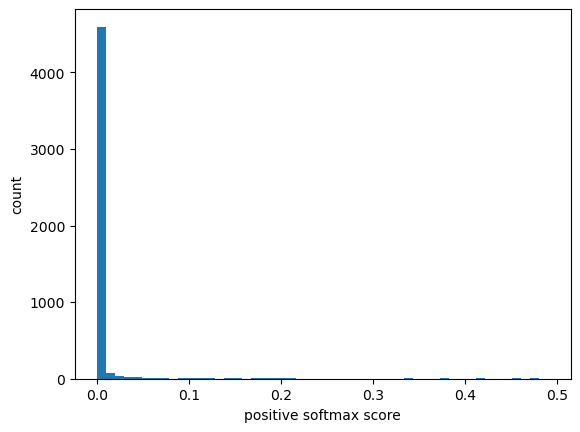

In [587]:
import ast
import matplotlib.pyplot as plt

pos_scores = (
    signal_df[signal_df['classification'] == 'NEUTRAL']['softmax_scores']
        .dropna()
        .apply(ast.literal_eval)        # string -> dict
        .apply(lambda d: d['positive']) # extract positive prob
)

plt.hist(pos_scores, bins=50)
plt.xlabel("positive softmax score")
plt.ylabel("count")
plt.show()


In [588]:
signal_df

,date,entity,classification,softmax_scores,entity_norm,matched_ticker
0,2020-06-01 19:26:12+00:00,Ted Baker,NEUTRAL,"{'positive': 0.001163970329798758, 'negative':...",ted baker,NaN
8,2020-06-01 19:14:00+00:00,Springboard,NEUTRAL,"{'positive': 0.0457630418241024, 'negative': 0...",springboard,NaN
15,2020-06-01 18:57:31+00:00,Equality and Human Rights Commission,NEUTRAL,"{'positive': 2.4746907001826912e-05, 'negative...",equality and human rights commission,NaN
24,2020-06-01 18:02:51+00:00,Springboard,NEUTRAL,"{'positive': 1.3598596524388995e-05, 'negative...",springboard,NaN
87,2020-06-01 18:02:51+00:00,DFS,NEUTRAL,"{'positive': 1.3598596524388995e-05, 'negative...",dfs,DFS
...,...,...,...,...,...,...
44762,2020-12-06 08:15:04+00:00,BBC MasterChef,NEUTRAL,"{'positive': 0.0001541223464300856, 'negative'...",bbc masterchef,NaN
44764,2020-12-04 13:40:10+00:00,Guardian,NEUTRAL,"{'positive': 7.577444921480492e-05, 'negative'...",guardian,NaN
44768,2020-12-04 13:40:10+00:00,JP Morgan,NEUTRAL,"{'positive': 0.00010029300028691068, 'negative...",jp morgan,JPM
44774,2020-12-02 10:28:00+00:00,Debenhams,NEUTRAL,"{'positive': 0.006469007581472397, 'negative':...",debenhams,NaN


In [589]:
filtered_df = signal_df.dropna(subset=['matched_ticker'])
filtered_df = filtered_df.rename(columns={'matched_ticker': 'TICKER'}) 

In [590]:
len(Counter(filtered_df['date']))

1132

In [591]:
########################################
# WEEKLY SIGNAL AGGREGATION
########################################

import ast
import numpy as np


def _softmax_sentiment_score(value):
    """Convert stored softmax dict/string into a signed sentiment score."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, dict):
        scores = value
    else:
        try:
            scores = ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return np.nan
    if not isinstance(scores, dict):
        return np.nan
    pos = float(scores.get('positive', 0.0))
    neg = float(scores.get('negative', 0.0))
    return pos - neg


def build_weekly_softmax_signal(df: pd.DataFrame) -> pd.DataFrame:
    work = df.dropna(subset=['TICKER']).copy()
    work['article_dt'] = pd.to_datetime(work['date'], utc=True, errors='coerce').dt.tz_convert(None)
    work['signal_score'] = work['softmax_scores'].apply(_softmax_sentiment_score)
    work = work.dropna(subset=['article_dt', 'signal_score'])
    work['week_date'] = work['article_dt'].dt.to_period('W-THU').dt.start_time

    weekly = (
        work.groupby(['TICKER', 'week_date'])
            .agg({
                'signal_score': 'mean',
                'classification': lambda x: x.value_counts().idxmax(),
                'article_dt': 'count'
            })
            .rename(columns={'classification': 'top_class', 'article_dt': 'n_articles'})
            .reset_index()
    )
    weekly['signal_score'] = weekly['signal_score'].fillna(0.0)
    return weekly

weekly_signal = build_weekly_softmax_signal(filtered_df)
weekly_signal.head()


,TICKER,week_date,signal_score,top_class,n_articles
0,AAL,2020-07-17,-0.998548,NEGATIVE,1
1,AAL,2020-08-14,0.012406,NEUTRAL,2
2,AAL,2020-08-21,0.001802,NEUTRAL,1
3,AAL,2020-09-18,-0.186135,NEUTRAL,1
4,AAL,2020-10-02,0.000207,NEUTRAL,1


In [592]:
weekly_signal[weekly_signal['TICKER'] == 'MSFT'].sort_values('week_date')

,TICKER,week_date,signal_score,top_class,n_articles
717,MSFT,2020-05-29,0.001479,NEUTRAL,3
718,MSFT,2020-06-05,0.137984,NEUTRAL,7
719,MSFT,2020-06-12,0.000018,NEUTRAL,2
720,MSFT,2020-06-19,-0.000666,NEUTRAL,5
721,MSFT,2020-06-26,-0.000277,NEUTRAL,1
722,MSFT,2020-07-17,0.007378,NEUTRAL,3
723,MSFT,2020-07-24,-0.010053,NEUTRAL,4
724,MSFT,2020-07-31,-0.020273,NEUTRAL,11
725,MSFT,2020-08-07,-0.085146,NEUTRAL,8
726,MSFT,2020-08-14,0.100767,NEUTRAL,7


In [593]:
import pandas as pd
import numpy as np

def compute_ticker_weekly(
    ret_df: pd.DataFrame,
    lookback_weeks: int = 52,
    skip_weeks: int = 4,
    week_rule: str = "W-FRI",
    col_ticker: str = "TICKER",
    col_date: str = "date",
    col_ret: str = "RET",
    out_mom: str = "MOM",
    out_wret: str = "WRET",
    return_daily_aligned: bool = False,
    ffill_to_next_week: bool = False
) -> pd.DataFrame:
    """
    Weekly L–G momentum using *weekly* compounded returns, also includes weekly returns.

    Momentum on week t is cumulative return from [t-(G+L)+1, ..., t-G] in weeks.

    If return_daily_aligned=False -> returns a weekly panel (PERMNO-week level).
    If return_daily_aligned=True  -> merges weekly MOM and weekly RET back to the daily panel.
    """
    df = ret_df.copy()
    df[col_date] = pd.to_datetime(df[col_date])
    df = df.sort_values([col_ticker, col_date])

    # === 1. Convert daily returns to weekly log-returns ===
    df["_logret"] = np.log1p(df[col_ret].astype(float).fillna(0.0).clip(lower=-0.999999))

    # === 2. Resample to weekly frequency per ticker ===
    wk = (
        df.set_index(col_date)
          .groupby(col_ticker, group_keys=True)["_logret"]
          .resample(week_rule)
          .sum()
          .rename("logret_w")
          .reset_index()
    )

    # Weekly compounded simple return
    wk[out_wret] = np.expm1(wk["logret_w"])

    # === 3. Compute cumulative sums of weekly log returns ===
    wk["csum"] = wk.groupby(col_ticker)["logret_w"].cumsum()

    # End of window: t - G
    wk["csum_end"] = wk.groupby(col_ticker)["csum"].shift(skip_weeks)

    # Start of window: t - (L+G)
    wk["csum_start"] = wk.groupby(col_ticker)["csum_end"].shift(lookback_weeks)

    wk_out = wk[[col_ticker, col_date, out_wret]].rename(columns={col_date: "week_date"})

    # === 5. Return weekly panel ===
    if not return_daily_aligned:
        return wk_out

    # === 6. Or merge back to daily panel ===
    daily = ret_df.copy()
    daily[col_date] = pd.to_datetime(daily[col_date])

    # build mapping from each daily date to its week anchor (Friday)
    all_days = (
        daily[[col_date]]
        .drop_duplicates()
        .sort_values(col_date)
        .set_index(col_date)
    )
    anchors = all_days.resample(week_rule).last().index
    mapper = pd.Series(anchors, index=anchors)
    mapper = mapper.reindex(all_days.index, method="ffill")
    mapper.name = "week_date"
    mapper = mapper.reset_index().rename(columns={col_date: "date"})

    daily = daily.merge(mapper, left_on=col_date, right_on="date", how="left").drop(columns=["date"])
    out = daily.merge(wk_out, on=[col_ticker, "week_date"], how="left")

    if ffill_to_next_week:
        out = out.sort_values([col_ticker, col_date])
        out[[out_mom, out_wret]] = out.groupby(col_ticker)[[out_mom, out_wret]].ffill()

    return out


In [594]:
ret_df = pd.read_csv('momentum/s&p100ret.csv')
ret_df['TICKER'] = ret_df['TICKER'].str.strip() 
ret_df['RET'] = pd.to_numeric(ret_df['RET'], errors='coerce') 
ret_df['date'] = pd.to_datetime(ret_df['date'], format='%Y-%m-%d')
#ret_df = ret_df.dropna(subset=['RET'])
weekly_returns = compute_ticker_weekly(ret_df, lookback_weeks=12, skip_weeks=1)
weekly_returns.head()


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_55149/1046434888.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ret_df = pd.read_csv('momentum/s&p100ret.csv')


,TICKER,week_date,WRET
0,AAPL,2019-01-04,-0.060099
1,AAPL,2019-01-11,0.027182
2,AAPL,2019-01-18,0.029747
3,AAPL,2019-01-25,0.005994
4,AAPL,2019-02-01,0.055527


In [595]:
weekly_alpha = (
    weekly_returns.merge(weekly_signal, on=['TICKER', 'week_date'], how='left')
        .rename(columns={'signal_score': 'SENT'})
        .sort_values(['week_date', 'TICKER'])
        .reset_index(drop=True)
)


In [596]:
########################################
# WEEKLY BACKTEST
########################################

LONG_PCT = 0.1
SHORT_PCT = 0.1
LEVERAGE = 1.0
HOLDING_WEEKS = 1

def prepare_weekly_signal(df: pd.DataFrame, signal_col: str) -> pd.DataFrame:
    use_cols = ['week_date', 'TICKER', 'WRET', signal_col]
    out = df[use_cols].dropna(subset=['WRET']).copy()
    out['week_date'] = pd.to_datetime(out['week_date'])
    return out.sort_values(['TICKER', 'week_date'])

def make_signal(df_slice: pd.DataFrame, col_signal: str) -> pd.Series:
    return df_slice.set_index('TICKER')[col_signal]

def construct_weights(signal_cs: pd.Series, long_pct=LONG_PCT, short_pct=SHORT_PCT, gross_leverage=LEVERAGE) -> pd.Series:
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    ranked = sig.sort_values(ascending=False)
    w_long = pd.Series(1 / n_long, index=ranked.index[:n_long])
    w_short = pd.Series(-1 / n_short, index=ranked.index[-n_short:])
    w = pd.concat([w_long, w_short])
    gross = w.abs().sum()
    if gross > 0:
        w *= gross_leverage / gross
    return w

def build_weight_panel(df: pd.DataFrame, holding_weeks: int, col_signal: str) -> pd.DataFrame:
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    for w in all_weeks:
        cs_slice = df[df['week_date'] == w]
        sig_cs = make_signal(cs_slice, col_signal)
        w_cs = construct_weights(sig_cs)
        if w_cs.empty:
            continue
        hold_weeks = all_weeks[all_weeks.index(w): all_weeks.index(w) + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({'week_date': hw, 'TICKER': w_cs.index, 'weight': w_cs.values}))
    return pd.concat(recs, ignore_index=True) if recs else pd.DataFrame(columns=['week_date','TICKER','weight'])

def run_weekly_signal_backtest(weekly_alpha: pd.DataFrame, signal_col: str = 'SENT') -> dict:
    df = prepare_weekly_signal(weekly_alpha, signal_col)
    weight_panel = build_weight_panel(df, holding_weeks=HOLDING_WEEKS, col_signal=signal_col)
    weekly_perf = compute_pnl_timeseries(df, weight_panel)
    return {'weekly_perf': weekly_perf, 'weights': weight_panel}


def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['RET_fwd'] = df.groupby('TICKER')['WRET'].shift(-1)

    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_fwd']],
        on=['TICKER', 'week_date'],
        how='left'
    )
    merged['pnl'] = merged['weight'] * merged['RET_fwd']

    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = -1 * x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl - short_pnl
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    benchmark = (
        df.dropna(subset=['RET_fwd'])
          .groupby('week_date')['RET_fwd']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    pnl['cum_ret'] = pnl['port_ret'].cumsum()
    pnl['cum_ret_long'] = pnl['port_ret_long'].cumsum()
    pnl['cum_ret_short'] = pnl['port_ret_short'].cumsum()
    pnl['benchmark_cum_ret'] = pnl['benchmark_ret'].cumsum()

    return pnl


backtest_results = run_weekly_signal_backtest(weekly_alpha, signal_col='SENT')
backtest_results['weekly_perf'].head()


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_55149/314575441.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


,week_date,port_ret_long,port_ret_short,port_ret,benchmark_ret,excess_ret,cum_ret,cum_ret_long,cum_ret_short,benchmark_cum_ret
0,2020-05-29,0.002702,0.129391,-0.126689,0.071131,-0.197820,-0.126689,0.002702,0.129391,0.071131
1,2020-06-05,0.011750,-0.028737,0.040487,-0.053549,0.094036,-0.086202,0.014452,0.100654,0.017582
2,2020-06-12,0.009160,-0.003363,0.012523,0.017190,-0.004667,-0.073679,0.023612,0.097291,0.034773
3,2020-06-19,-0.002861,-0.005333,0.002472,-0.040546,0.043018,-0.071207,0.020751,0.091958,-0.005773
4,2020-06-26,0.035154,0.070190,-0.035036,0.041066,-0.076102,-0.106242,0.055906,0.162148,0.035293


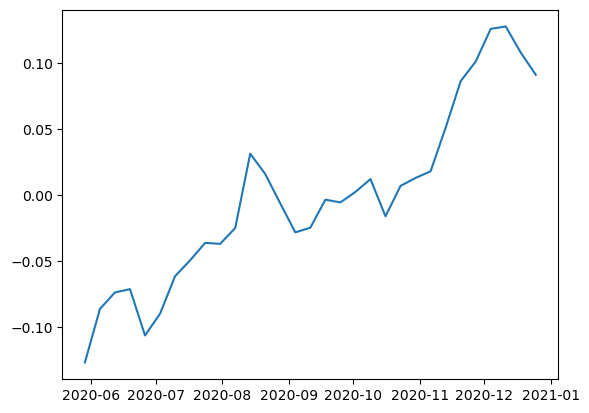

In [597]:
plt.plot(backtest_results['weekly_perf']['week_date'], backtest_results['weekly_perf']['cum_ret'], label='Strategy')

<Axes: title={'center': 'Weekly Momentum Backtest'}, xlabel='week_date'>

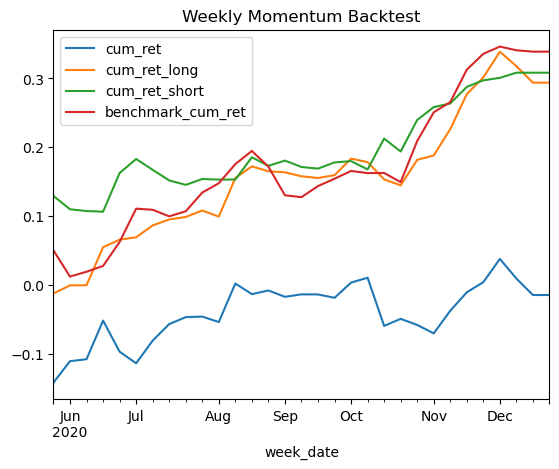

In [417]:
backtest_results['weekly_perf'][['week_date','cum_ret', 'cum_ret_long', 'cum_ret_short', 'benchmark_cum_ret']].plot(x='week_date', y=['cum_ret', 'cum_ret_long', 'cum_ret_short', 'benchmark_cum_ret'], title='Weekly Momentum Backtest')